In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [17]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/segmentation'

In [18]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [19]:
pixels = 256

In [20]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [21]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [22]:
def binarize(img):
    img[img>0] = 1
    return img

In [23]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

In [24]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(path, 'images', masks_name[i]))

In [ ]:
np.unique(masks)

In [ ]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [12]:
images.shape

(492, 256, 256, 1)

## Selección de pesos por imagen

Vamos a ver las imagenes y elegir las de peor calidad para darles más peso

In [13]:
# for i in range(len(images)):
#     print(i)
#     plt.figure(figsize=(100, 100))
#     plt.subplot(1,len(images),i+1)
#     plt.imshow(images[i])
#     plt.show()

In [14]:
# bad_quality = [14,15,34] + [i for i in range(39,56)] + [65,73,76,77]

In [15]:
# importance = np.array([1 if i in bad_quality else 0.75 for i in range(len(images))])

# Aumento de datos

In [16]:
import imutils

In [17]:
def augment(input_image, input_mask):
    r = np.random.randint(-60,60)
    # Random flipping of the image and mask
    input_image = np.expand_dims(imutils.rotate(input_image, angle=r),  axis=-1)
    input_mask = np.expand_dims(imutils.rotate(input_mask, angle=r), axis=-1)
    input_mask = binarize(input_mask)
    return input_image, input_mask

Nuevas imagenes con rotacion random (las tengo que binarizar porque sino al rotar se modifica)

In [18]:
new_img = np.zeros((len(masks_name), pixels,pixels,1))
new_mask = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    img, mask = augment(images[i], masks[i])
    new_img[i, ...] = img
    new_mask[i,...] = mask

In [19]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)
# importance = np.concatenate((importance, importance), axis=0)

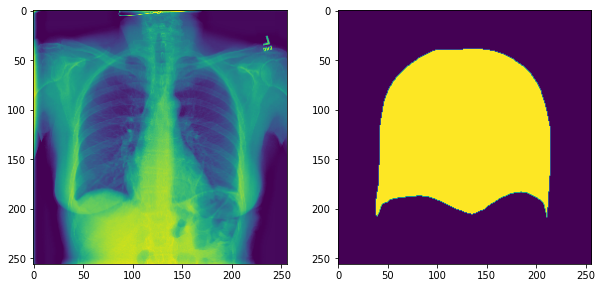

In [20]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [21]:
images.shape

(984, 256, 256, 1)

In [22]:
masks.shape

(984, 256, 256, 1)

In [23]:
np.unique(masks)

array([0., 1.])

# Models

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn import model_selection

In [25]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [26]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

## Mask model

Cargo el modelo que transforma una máscara en otra igual, y me quedo solo con la priemra parte, hasta el punto de menores dimensiones

In [27]:
mask_model = keras.models.load_model('/home/mr1142/Documents/Data/models/mask_1.h5', 
                                     custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

In [28]:
# Se crea otro modelo con el input del primero y con el output de la capa 18 del otro
sub_mask = tf.keras.Model(inputs=mask_model.input, outputs=mask_model.layers[18].output)

In [29]:
sub_mask.trainable = False

In [30]:
sub_mask.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

## Modelo completo

### Funciones

Definimos una nueva loss, para la primera parte (mascara vs. mascara) usaremos dice, pero para la segunda utilizaremos diferencia absoluta

In [31]:
def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + loss2
    return loss

In [32]:
def double_conv_block(x, n_filters):
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with eLU activation
    x = double_conv_block(x, n_filters)
    return x

### Modelo version 1

Creamos el modelo introduciendo tres inputs, ya que sino era imposible ejecutar la loss.

Introducimos:

- La imagen de entrada
- La capa de salida (real)
- La capa despues de la transformación del segundo modelo
    
Además al final del modelo añadimos la sub_mask

Y añadimos la loss al final del modelo.

In [33]:
def build_unet_model():
    # inputs
    X_train = layers.Input(shape=(pixels,pixels,1))
    # Y_train = layers.Input(shape=(pixels,pixels,1))
        
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(X_train, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs1 = layers.Conv2D(1, 1, padding="same", activation = "sigmoid", name = 'outputs2')(u9)
    
    # Mask 
    # outputs2 = sub_mask(outputs1)
    # Y_train2 = sub_mask(Y_train)
    
    # unet_model = tf.keras.Model(inputs=[X_train, Y_train], outputs=[outputs2, outputs1, Y_train2], name="U-Net")
    unet_model = tf.keras.Model(inputs= X_train, outputs= outputs1, name="U-Net")

    
    # unet_model.add_loss(MyLoss(Y_train, Y_train2, outputs1, outputs2))
    
    return unet_model

In [34]:
unet_model = build_unet_model()

In [35]:
unet_model.outputs

[<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'outputs2')>]

In [36]:
# unet_model.summary()

In [37]:
len(unet_model.trainable_variables)

46

In [38]:
sub_mask.trainable = False

In [39]:
len(unet_model.trainable_variables)

46

## Metricas

In [40]:
import datetime
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + 'U-Net1_doble_loss_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience = 10)

## Compilado

In [42]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  loss=MyLoss,
                  metrics = [dice_coef_loss, loss_mask])

In [43]:
batch = 8
epoch = 100

In [44]:
tf.config.run_functions_eagerly(True)

In [45]:
history = unet_model.fit(images,masks,
                         batch_size = batch,
                         epochs = epoch,
                         # callbacks = [tensorboard_callback, early_stop],
                         # sample_weight = importance,
                         # validation_data = (X_test, Y_test),
                         shuffle = True,
                         validation_split=0.2,
                         verbose = 1)

/home/mr1142/miniconda3/envs/init/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
98/99 [============================>.] - ETA: 0s - loss: 1.4956 - dice_coef_loss: 0.4364 - loss_mask: 1.0592

KeyboardInterrupt: 

# Validación

In [49]:
path = '/home/mr1142/Documents/Data/NIH/images_005'

In [50]:
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

In [51]:
pixels = 256

In [52]:
def apply_mask(img, mask):
    img[mask!=1]=0
    return img

In [58]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict([img[np.newaxis,...], masks[0][np.newaxis,...], masks2[0][np.newaxis,...]])[1][0]

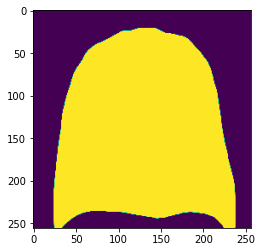

In [59]:
plt.imshow(mask)

In [1]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict([img[np.newaxis,...], masks[0][np.newaxis,...], masks2[0][np.newaxis,...]])[1][0]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

NameError: name 'np' is not defined

In [234]:
unet_model.save('/home/mr1142/Documents/Data/models/unet_doble_output.h5')